<h1 style="font-size: 38px; text-align: center; color: blue">The implementation of deep learning to develop an adequate tool for identifying the bumblebee species in Ireland</h1>

<br> </br>

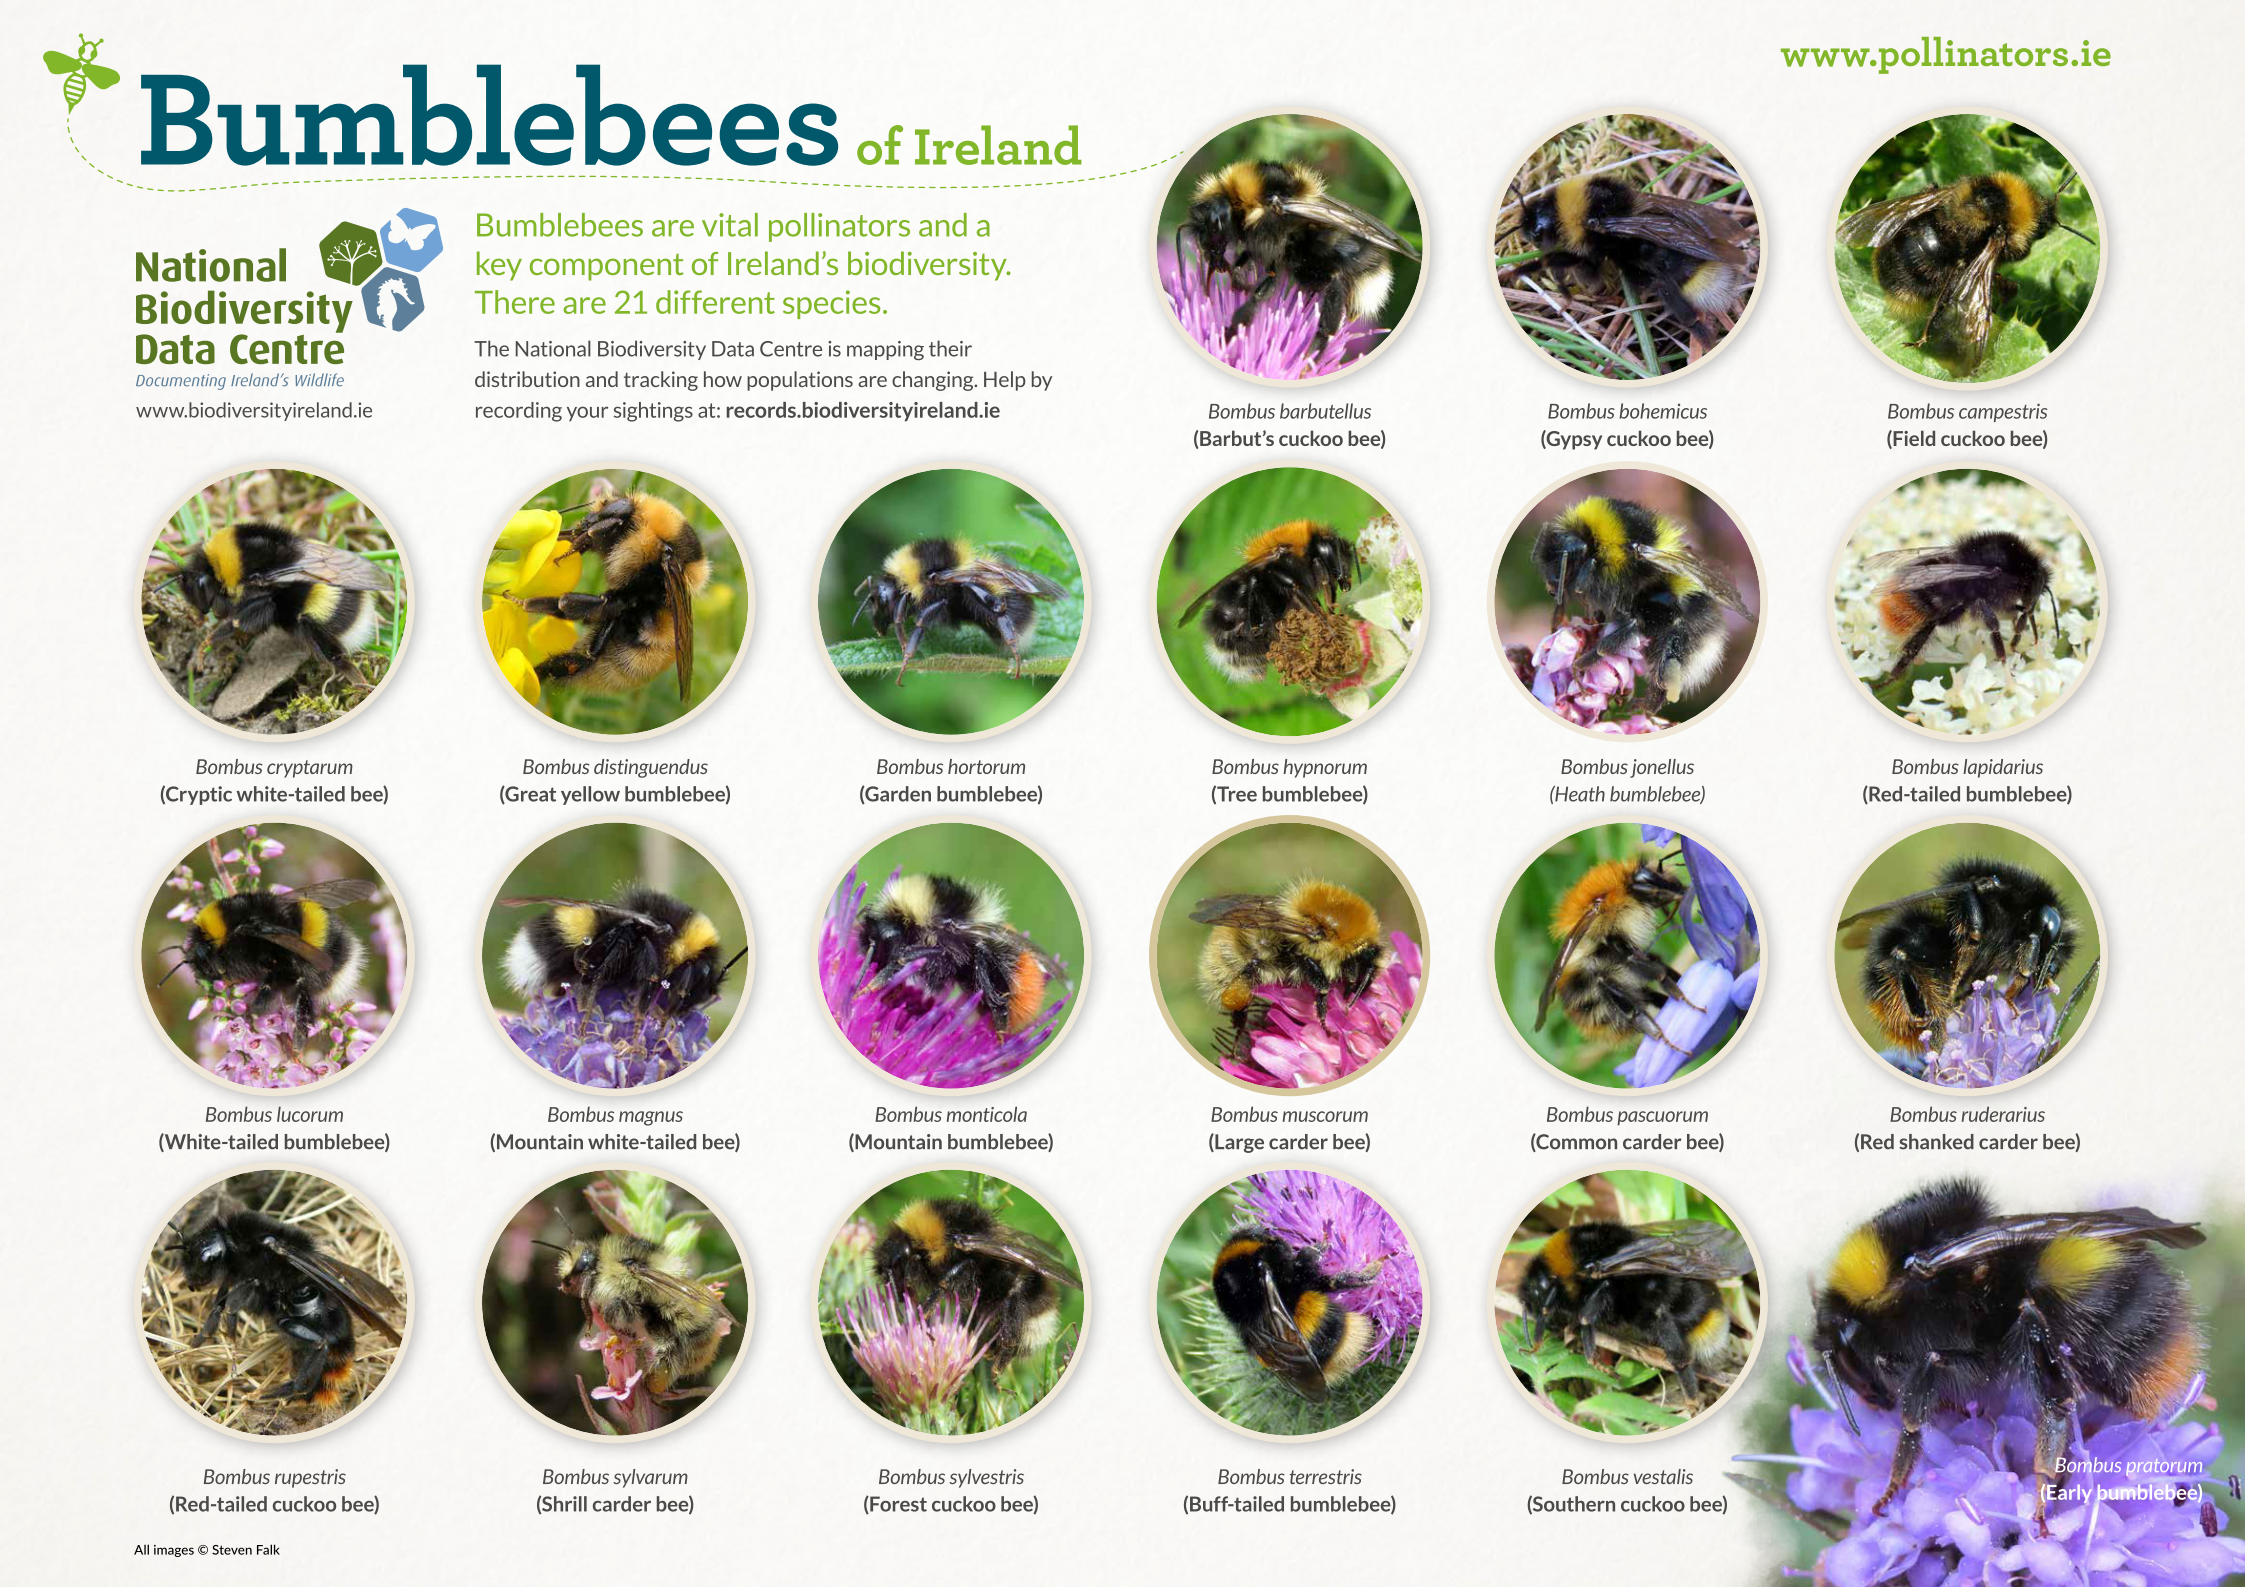

<br> </br>

<h1 style="font-size: 28px; text-align: center; color: green"> 4. Model Evaluation using Local Interpretable Model-agnostic Explanations (LIME) </h1>

<br> </br>

In [11]:
#!pip3 install lime

In [12]:
# Import libraries
import os
import shutil
import random
import xml.etree.ElementTree as ET
import cv2

import warnings
warnings.filterwarnings("ignore")

# Import libraries
import pathlib
import itertools
import glob
import numpy as np

import PIL
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [13]:
test_data_dir = pathlib.Path('/home/hduser/Desktop/final dataset testing/test')

print(test_data_dir)

/home/hduser/Desktop/final dataset testing/test


In [ ]:
# Get the list of subdirectories (species)
species_list = [subdir.name for subdir in test_data_dir.glob('*')]

# Create a subplot grid
fig, axes = plt.subplots(21, 2, figsize=(15, 50))

# Adjust layout to provide space for titles
plt.subplots_adjust(hspace=0.5)

# Loop through each species
for i, species in enumerate(species_list):
    # Get two images from each species
    species_images = list(test_data_dir.glob(f'{species}/*'))[:2]

    # Loop through each image for the species
    for j, image_path in enumerate(species_images):
        image = Image.open(str(image_path))

        # Extract filename from path
        filename = os.path.basename(image_path)

        # Display the image on the subplot
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'{species}\n{filename}', y=1.02)  # Adjust y position for title
        axes[i, j].axis('off')

plt.show()

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: orange"> 4.1 Keras </h1>
<br> </br>

In [23]:
import tensorflow as tf
from tensorflow import keras

from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, confusion_matrix

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg19, mobilenet_v2
from tensorflow.keras.applications import inception_v3, efficientnet_v2
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread

from functools import partial

2023-12-06 14:47:28.083828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 14:47:28.122271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 14:47:28.122304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 14:47:28.123079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 14:47:28.128954: I tensorflow/core/platform/cpu_feature_guar

In [38]:
explainer = lime_image.LimeImageExplainer()

<br> </br>
- <h1 style="font-size: 16px"> Create functions for testing and evaluating in Keras. </h1>
<br> </br>

In [ ]:
def plot_confusion_matrix_test_keras(model, batches, model_name):
    # Get the number of batches
    num_batches = len(batches)

    # Make predictions for each batch
    predictions = []
    true_labels = []

    for i in range(num_batches):
        # Get a batch of data
        batch_data, batch_labels = batches[i]

        # Make predictions for the batch
        batch_predictions = model.predict(batch_data)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        
        # Extract true labels from the batch
        true_labels.extend(np.argmax(batch_labels, axis=1))

    # Convert lists to numpy arrays
    predicted_labels = np.array(predictions)
    true_labels = np.array(true_labels)

    # Get class names from the data generator
    class_names = list(batches.class_indices.keys())

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Loop to annotate each cell in the heatmap
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center',
                     bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {model_name} Model on Test Dataset', fontsize=20)
    plt.show()

In [ ]:
def transform_img_fn(path_list, model, height, width):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = model.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
def print_accuracy_keras(model, test_batches, model_name):
    # Predict on the test batches
    predictions = model.predict(test_batches)

    # Extract class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Assuming you have the true labels for your test data
    true_labels = test_batches.classes

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_classes)

    print(f"The overall test accuracy score of {model_name}:\n {accuracy * 100:.2f}%")

In [ ]:
def plot_heatmap_keras(explanation, default_value=0):
    # Select the top class from the explanation
    ind = explanation.top_labels[0]

    # Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])

    # Create a custom function to handle default value
    def get_with_default(key):
        return dict_heatmap.get(key, default_value)

    # Vectorize the function using np.vectorize
    vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
    heatmap = vectorized_get_with_default(explanation.segments)

    # Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap='RdYlBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
    plt.colorbar()
    plt.show()

<br> </br>
## 4.1.1 InceptionV3
<br> </br>

In [ ]:
# Load model architecture from JSON
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_inceptionv3 = model_from_json(loaded_model_json)

# Load model weights from HDF5
model_inceptionv3.load_weights("model_inceptionv3_weights.h5")

In [ ]:
# # Load model architecture from JSON
# with open("model_inception.json", "r") as json_file:
#     loaded_model_json = json_file.read()
# model_inceptionv3 = model_from_json(loaded_model_json)

# # Load model weights from HDF5
# model_inceptionv3.load_weights("model_inception_weights.h5")

In [ ]:
# Specify image size and batch size
img_height_inception, img_width_inception = (299, 299)
batch_size = 32

In [ ]:
test_batches_inception = ImageDataGenerator(preprocessing_function=
                                            tf.keras.applications.inception_v3.preprocess_input) \
                    .flow_from_directory(test_data_dir, 
                                         target_size=(img_height_inception, img_width_inception),
                                         batch_size=batch_size, class_mode='categorical', 
                                         shuffle=False)

In [ ]:
# Assuming you have already created test_batches_inception
class_names = list(test_batches_inception.class_indices.keys())

# Now, class_names is a list containing the class names
print(class_names)

In [ ]:
print_accuracy_keras(model_inceptionv3, test_batches_inception, 'InceptionV3')

In [ ]:
plot_confusion_matrix_test_keras(model_inceptionv3, test_batches_inception, 'InceptionV3')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

<br> </br>

In [ ]:
os.chdir(test_data_dir)
barbutellus = transform_img_fn(['./bombus barbutellus/bombus barbutellus inaturalist 15.1.jpg'], 
                               inception_v3, 
                               img_height_inception, 
                               img_width_inception)

plt.imshow(barbutellus[0] / 2 + 0.5)

preds = model_inceptionv3.predict(barbutellus)

# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation_inception = explainer.explain_instance(barbutellus[0].astype('double'), 
                                                   model_inceptionv3.predict, 
                                                   top_labels=5, 
                                                   hide_color=0, 
                                                   num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_inception.\
             get_image_and_mask(explanation_inception.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# temp, mask = explanation_inception.\
#              get_image_and_mask(explanation_inception.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_inception.\
             get_image_and_mask(explanation_inception.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_inception.\
             get_image_and_mask(explanation_inception.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plot_heatmap_keras(explanation_inception)

<br> </br>
## 4.1.2 ResNet101
<br> </br>

In [ ]:
# Load model architecture from JSON
with open("model_resnet.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_resnet101 = model_from_json(loaded_model_json)

# Load model weights from HDF5
model_resnet101.load_weights("model_resnet_weights.h5")

In [ ]:
# Specify image size and batch size
img_height_resnet, img_width_resnet = (224, 224)
batch_size = 32

In [ ]:
test_batches_resnet = ImageDataGenerator(preprocessing_function=
                                         tf.keras.applications.resnet.preprocess_input) \
                    .flow_from_directory(test_data_dir, 
                                         target_size=(img_height_resnet, img_width_resnet),
                                         batch_size=batch_size, class_mode='categorical', 
                                         shuffle=False)

In [ ]:
# Assuming you have already created test_batches_inception
class_names = list(test_batches_resnet.class_indices.keys())

# Now, class_names is a list containing the class names
print(class_names)

In [ ]:
print_accuracy_keras(model_resnet101, test_batches_resnet, 'ResNet101')

In [ ]:
plot_confusion_matrix_test_keras(model_resnet101, test_batches_resnet, 'ResNet101')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir(test_data_dir)
barbutellus = transform_img_fn(['./bombus barbutellus/bombus barbutellus inaturalist 15.1.jpg'], 
                               resnet, 
                               img_height_resnet, 
                               img_width_resnet)

plt.imshow(barbutellus[0] / 2 + 0.5)

preds = model_resnet101.predict(barbutellus)

# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation_resnet = explainer.explain_instance(barbutellus[0].astype('double'), 
                                                model_resnet101.predict, 
                                                top_labels=5, 
                                                hide_color=0, 
                                                num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_resnet.\
             get_image_and_mask(explanation_resnet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# temp, mask = explanation_resnet.\
#              get_image_and_mask(explanation_resnet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_resnet.\
             get_image_and_mask(explanation_resnet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_resnet.\
             get_image_and_mask(explanation_resnet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plot_heatmap_keras(explanation_resnet)

<br> </br>
## 4.1.3 VGG19
<br> </br>

In [ ]:
# Load model architecture from JSON
with open("model_vgg.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_vgg19 = model_from_json(loaded_model_json)

# Load model weights from HDF5
model_vgg19.load_weights("model_vgg_weights.h5")

In [ ]:
# Specify image size and batch size
img_height_vgg, img_width_vgg = (224, 224)
batch_size = 32

In [ ]:
test_batches_vgg = ImageDataGenerator(preprocessing_function=
                                      tf.keras.applications.vgg19.preprocess_input) \
                    .flow_from_directory(test_data_dir, 
                                         target_size=(img_height_vgg, img_width_vgg),
                                         batch_size=batch_size, class_mode='categorical', 
                                         shuffle=False)

In [ ]:
# Assuming you have already created test_batches_inception
class_names = list(test_batches_vgg.class_indices.keys())

# Now, class_names is a list containing the class names
print(class_names)

In [ ]:
print_accuracy_keras(model_vgg19, test_batches_vgg, 'VGG19')

In [ ]:
plot_confusion_matrix_test_keras(model_vgg19, test_batches_vgg, 'VGG19')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

<br> </br>

In [ ]:
os.chdir(test_data_dir)
barbutellus = transform_img_fn(['./bombus barbutellus/bombus barbutellus inaturalist 15.1.jpg'], 
                               vgg19, 
                               img_height_vgg, 
                               img_width_vgg)

plt.imshow(barbutellus[0] / 2 + 0.5)

preds = model_vgg19.predict(barbutellus)

# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation_vgg = explainer.explain_instance(barbutellus[0].astype('double'), 
                                             model_vgg19.predict, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_vgg.\
             get_image_and_mask(explanation_vgg.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# temp, mask = explanation_vgg.\
#              get_image_and_mask(explanation_vgg.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_vgg.\
             get_image_and_mask(explanation_vgg.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_vgg.\
             get_image_and_mask(explanation_vgg.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plot_heatmap_keras(explanation_vgg)

<br> </br>
## 4.1.4 MobileNetV3Large
<br> </br>

In [ ]:
# Load model architecture from JSON
with open("model_mobilenet.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_mobilenetv3 = model_from_json(loaded_model_json)

# Load model weights from HDF5
model_mobilenetv3.load_weights("model_mobilenet_weights.h5")

In [ ]:
# Specify image size and batch size
img_height_mobilenet, img_width_mobilenet = (224, 224)
batch_size = 32

In [ ]:
test_batches_mobilenet = ImageDataGenerator(preprocessing_function=
                                            tf.keras.applications.mobilenet_v3.preprocess_input) \
                    .flow_from_directory(test_data_dir, 
                                         target_size=(img_height_mobilenet, img_width_mobilenet),
                                         batch_size=batch_size, class_mode='categorical', 
                                         shuffle=False)

In [ ]:
# Assuming you have already created test_batches_inception
class_names = list(test_batches_mobilenet.class_indices.keys())

# Now, class_names is a list containing the class names
print(class_names)

In [ ]:
print_accuracy_keras(model_mobilenetv3, test_batches_mobilenet, 'MobileNetV3 Large')

In [ ]:
plot_confusion_matrix_test_keras(model_mobilenetv3, test_batches_mobilenet, 'MobileNetV3 Large')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir(test_data_dir)
cryptarum = transform_img_fn(['./bombus cryptarum/bombus cryptarum inaturalist 83.jpg'],
                             mobilenet_v3, 
                             img_height_mobilenet, 
                             img_width_mobilenet)

plt.imshow(cryptarum[0] / 2 + 0.5)

preds = model_mobilenetv3.predict(cryptarum)

# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation_mobilenet = explainer.explain_instance(cryptarum[0].astype('double'), 
                                                   model_mobilenetv3.predict, 
                                                   top_labels=5, 
                                                   hide_color=0, 
                                                   num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_mobilenet.\
             get_image_and_mask(explanation_mobilenet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# temp, mask = explanation_mobilenet.\
#              get_image_and_mask(explanation_mobilenet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_mobilenet.\
             get_image_and_mask(explanation_mobilenet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_mobilenet.\
             get_image_and_mask(explanation_mobilenet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plot_heatmap_keras(explanation_mobilenet)

<br> </br>
## 4.1.5 EfficientNetV2 Large
<br> </br>

In [ ]:
# Load model architecture from JSON
with open("model_efficientnet.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_efficientnetv2 = model_from_json(loaded_model_json)

# Load model weights from HDF5
model_efficientnetv2.load_weights("model_efficientnet_weights.h5")

In [ ]:
# Specify image size and batch size
img_height_efficientnet, img_width_efficientnet = (240, 240)
batch_size = 32

In [ ]:
test_batches_efficientnet = ImageDataGenerator(preprocessing_function=
                                               tf.keras.applications.efficientnet_v2.preprocess_input) \
                    .flow_from_directory(test_data_dir, 
                                         target_size=(img_height_efficientnet, img_width_efficientnet),
                                         batch_size=batch_size, class_mode='categorical', 
                                         shuffle=False)

In [ ]:
# Assuming you have already created test_batches_inception
class_names = list(test_batches_efficientnet.class_indices.keys())

# Now, class_names is a list containing the class names
print(class_names)

In [ ]:
print_accuracy_keras(model_efficientnetv2, test_batches_efficientnet, 'EfficientNetV2_Large')

In [ ]:
plot_confusion_matrix_test_keras(model_efficientnetv2, test_batches_efficientnet, 'EfficientNetV2_Large')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir(test_data_dir)
cryptarum = transform_img_fn(['./bombus cryptarum/bombus cryptarum inaturalist 83.jpg'],
                             efficientnet_v2, 
                             img_height_efficientnet, 
                             img_width_efficientnet)

plt.imshow(cryptarum[0] / 2 + 0.5)

preds = model_efficientnetv2.predict(cryptarum)

# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")

In [ ]:
explanation_efficientnet = explainer.explain_instance(cryptarum[0].astype('double'), 
                                                      model_efficientnetv2.predict, 
                                                      top_labels=5, 
                                                      hide_color=0, 
                                                      num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_efficientnet.\
             get_image_and_mask(explanation_efficientnet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
# temp, mask = explanation_efficientnet.\
#              get_image_and_mask(explanation_efficientnet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_efficientnet.\
             get_image_and_mask(explanation_efficientnet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_efficientnet.\
             get_image_and_mask(explanation_efficientnet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
plot_heatmap_keras(explanation_efficientnet)

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: orange"> 4.2 Pytorch </h1>
<br> </br>

In [45]:
import torch

import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

import json

from torch.autograd import Variable
import torch.nn.functional as F

<br> </br>
- <h1 style="font-size: 16px"> Create functions for testing and evaluating in Pytorch. </h1>
<br> </br>

In [2]:
def plot_images(dataset, title):
    # Create a DataLoader for the dataset
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Retrieve a batch of images and labels
    images, labels = next(iter(loader))

    # Plotting code
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes = axes.flatten()

    for i in range(5):
        im = images[i].cpu().numpy().transpose((1, 2, 0))
        axes[i].imshow(im)
        axes[i].set_title(dataset.classes[labels[i]], size=10)
        axes[i].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [3]:
def pytorch_predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = data_transform['test']


    test_image = PIL.Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(8, dim=1)
        for i in range(8):
            print("Predcition", i+1, ":", class_names[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

In [4]:
def print_accuracy_pytorch(model, data_loader, model_name):
    device = torch.device("cpu")
    model.to(device)
    
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    print(f'The overall test accuracy score of {model_name}:\n {accuracy * 100:.2f}%')

In [5]:
def plot_confusion_matrix_test_pytorch(model, data_loader, model_name):
    device = torch.device("cpu")
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    class_names = test_dataset.classes
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Loop to annotate each cell in the heatmap
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center',
                     bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {model_name} on Test Dataset', fontsize=20)
    plt.show()

In [6]:
# Function for loading images
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with PIL.Image.open(f) as img:
            return img.convert('RGB')


# Function for transforming images to standard
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)


# Function for getting preditions
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

image_transform = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [7]:
def visualize_explanation_pytorch(explanation, default_value=0):
    """
    Visualize the explanation using a heatmap.

    Parameters:
    - explanation: LimeTabularExplainer explanation object
    - default_value: Default value for None entries in the heatmap

    Returns:
    None (Displays the heatmap using matplotlib)
    """
    # Select the same class explained on the figures above.
    ind = explanation.top_labels[0]

    # Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])

    # Create a custom function to handle default value
    def get_with_default(key):
        return dict_heatmap.get(key, default_value)

    # Vectorize the function using np.vectorize
    vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
    heatmap = vectorized_get_with_default(explanation.segments)

    # Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap='RdYlBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
    plt.colorbar()
    plt.show()

<br> </br>

In [8]:
input_size= 224

data_transform = { 
    'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [14]:
# Load test dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, 
                                    transform=data_transform['test'])

In [15]:
test_data_size = len(test_dataset)

print(test_data_size)

420


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


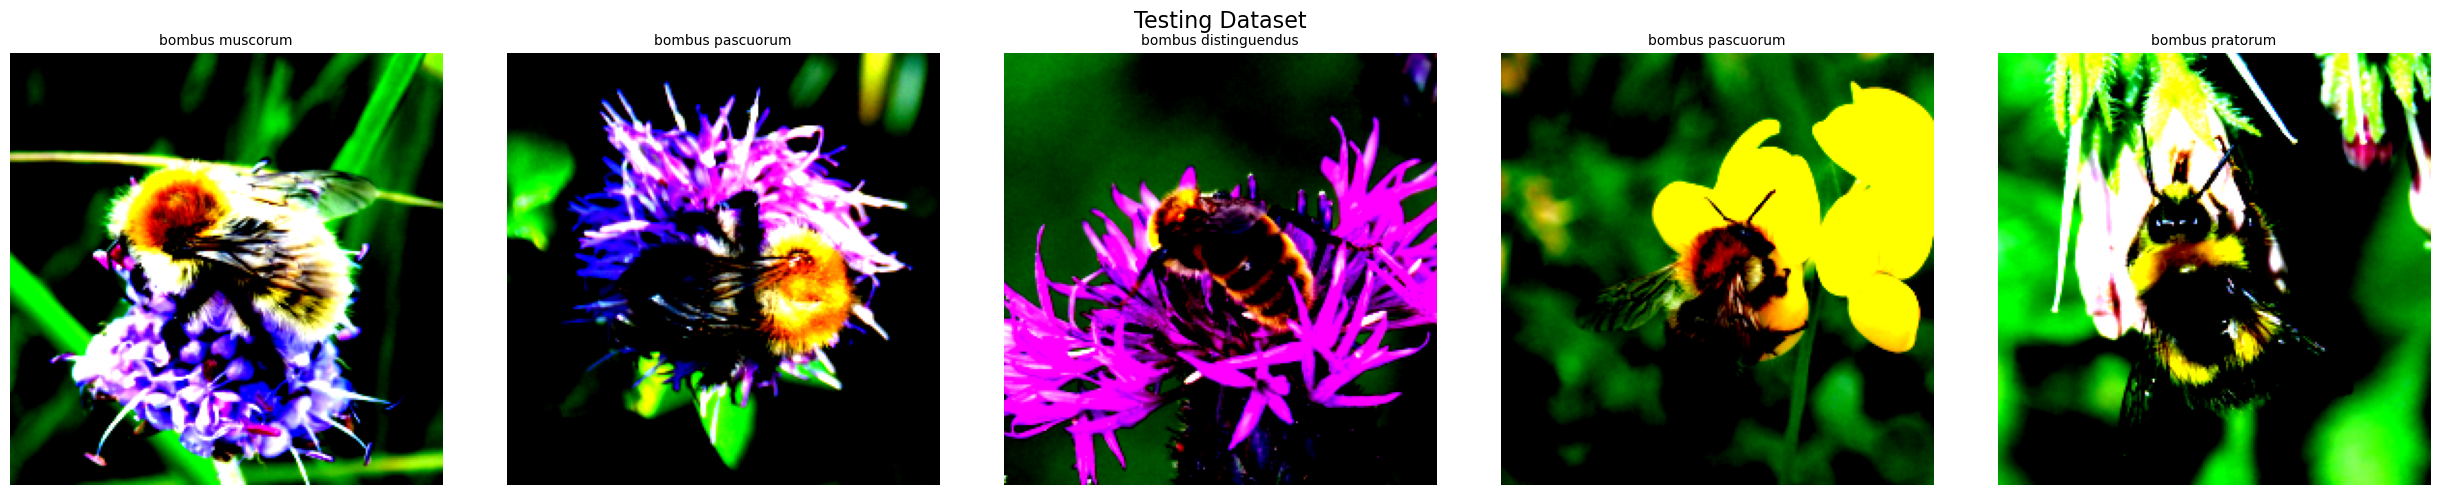

In [16]:
plot_images(test_dataset, 'Testing Dataset')

In [17]:
batch_size=32
num_workers=4

In [18]:
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers)

In [19]:
# Number of classes
num_classes = len(os.listdir(test_data_dir))
print(num_classes)

21


In [30]:
class_names = test_dataset.classes

<br> </br>
## 4.2.1 SqueezeNet
<br> </br>

In [20]:
os.chdir('/home/hduser/Desktop/final dataset testing/')
# Create an instance of the SqueezeNet model
model_squeezenet = models.squeezenet1_1(num_classes=num_classes, pretrained=False)

# Load the saved model weights
model_squeezenet.load_state_dict(torch.load("model_squeezenet.pth"))

# Set the model to evaluation mode
model_squeezenet.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [24]:
print_accuracy_pytorch(model_squeezenet, test_loader, 'SqueezeNet1_1')

The overall test accuracy score of SqueezeNet1_1:
 37.86%


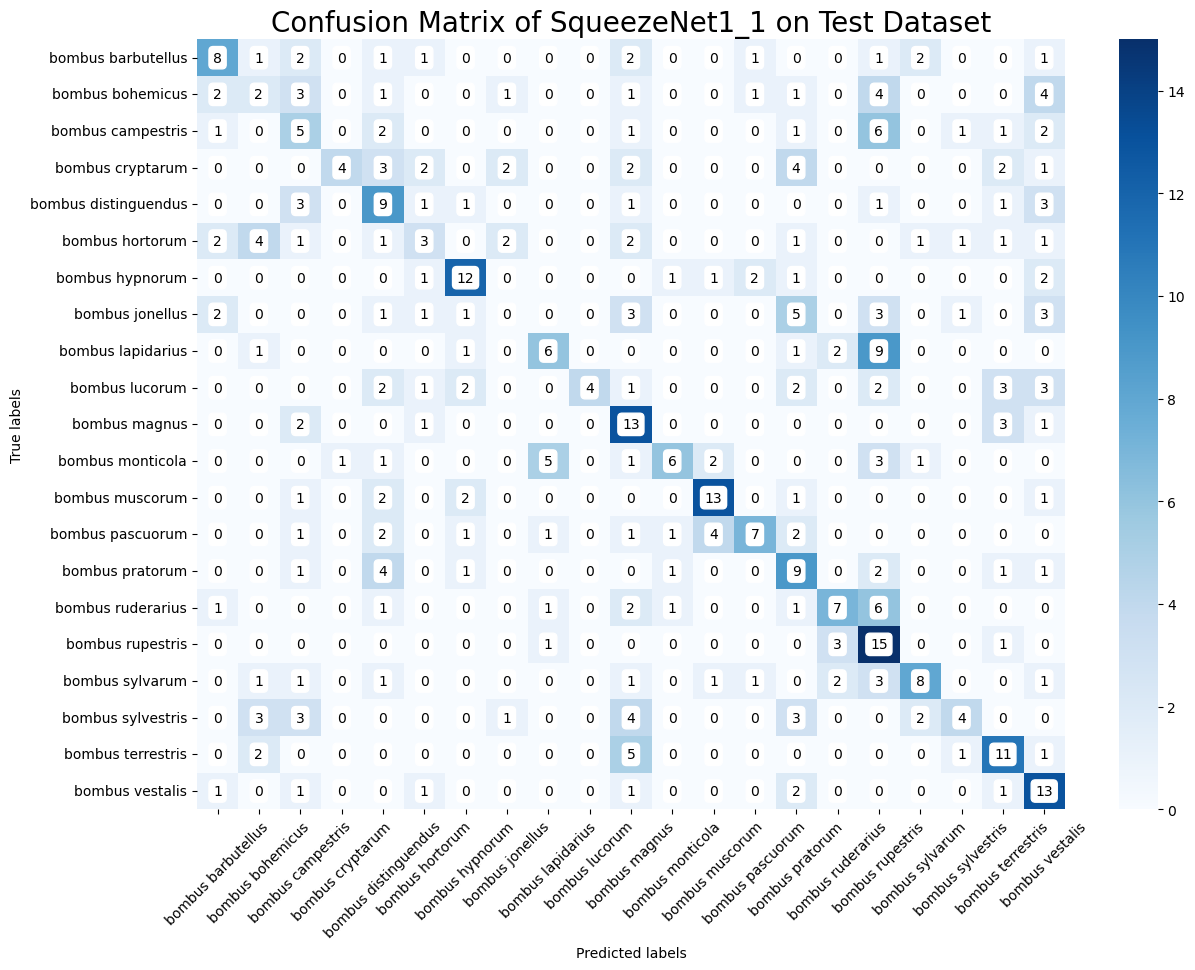

In [25]:
plot_confusion_matrix_test_pytorch(model_squeezenet, test_loader, 'SqueezeNet1_1')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [27]:
os.chdir('/home/hduser/Desktop/final dataset testing/test')

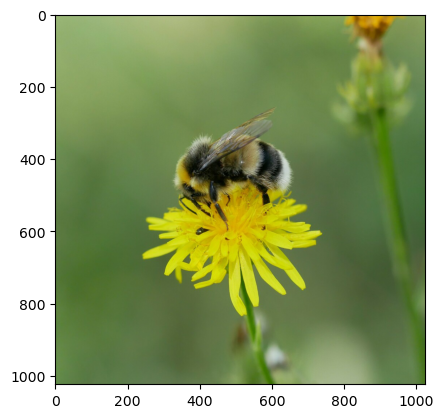

In [28]:
lucorum = get_image('./bombus lucorum/bombus lucorum inaturalist 13.jpg')
plt.imshow(lucorum)

In [31]:
print(class_names)

['bombus barbutellus', 'bombus bohemicus', 'bombus campestris', 'bombus cryptarum', 'bombus distinguendus', 'bombus hortorum', 'bombus hypnorum', 'bombus jonellus', 'bombus lapidarius', 'bombus lucorum', 'bombus magnus', 'bombus monticola', 'bombus muscorum', 'bombus pascuorum', 'bombus pratorum', 'bombus ruderarius', 'bombus rupestris', 'bombus sylvarum', 'bombus sylvestris', 'bombus terrestris', 'bombus vestalis']


Predcition 1 : bombus distinguendus , Score:  1890.0215
Predcition 2 : bombus jonellus , Score:  242.71364
Predcition 3 : bombus bohemicus , Score:  178.07617
Predcition 4 : bombus vestalis , Score:  154.52702
Predcition 5 : bombus hortorum , Score:  141.3345
Predcition 6 : bombus hypnorum , Score:  106.01291
Predcition 7 : bombus campestris , Score:  102.81343
Predcition 8 : bombus lucorum , Score:  101.88771


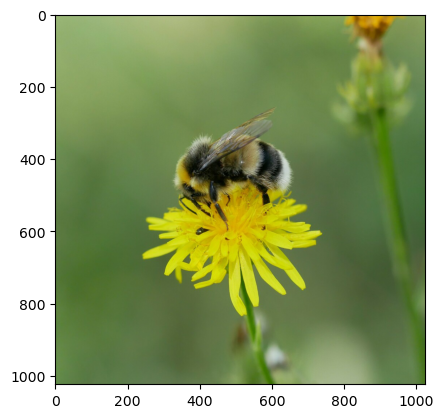

In [32]:
pytorch_predict(model_squeezenet, './bombus lucorum/bombus lucorum inaturalist 13.jpg')

In [33]:
lucorum_tensor = get_input_tensors(lucorum)
model_squeezenet.eval()
logits = model_squeezenet(lucorum_tensor)

In [34]:
print(logits)

tensor([[3.7218, 4.7363, 4.1542, 4.9516, 6.4110, 3.9217, 3.3982, 5.6449, 1.6930,
         5.1648, 4.3604, 1.8173, 1.9165, 0.8310, 3.6744, 2.1289, 3.7013, 3.4184,
         3.6879, 2.8525, 4.1064]], grad_fn=<ViewBackward0>)


In [35]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.33015323, 4, 'bombus distinguendus'),
 (0.15347175, 7, 'bombus jonellus'),
 (0.0949535, 9, 'bombus lucorum'),
 (0.07671989, 3, 'bombus cryptarum'),
 (0.061863836, 1, 'bombus bohemicus'))

In [46]:
def batch_predict_squeezenet(images):
    model_squeezenet.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_squeezenet.to(device)
    batch = batch.to(device)
    
    logits = model_squeezenet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [36]:
test_pred_squeezenet = batch_predict_squeezenet([image_transform(lucorum)])
class_label = test_pred_squeezenet.squeeze().argmax()
print(f'The top one predicted class label is {class_label}.')
print(f'The top one predicted class name is: {class_names[class_label]}.')

The top one predicted class label is 4.
The top one predicted class name is: bombus distinguendus.


In [39]:
explanation_squeezenet = explainer.explain_instance(np.array(image_transform(lucorum)), 
                                                    batch_predict_squeezenet,
                                                    top_labels=5, 
                                                    hide_color=0, 
                                                    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

<br> </br>
- top 3 superpixels that are most positive towards the class

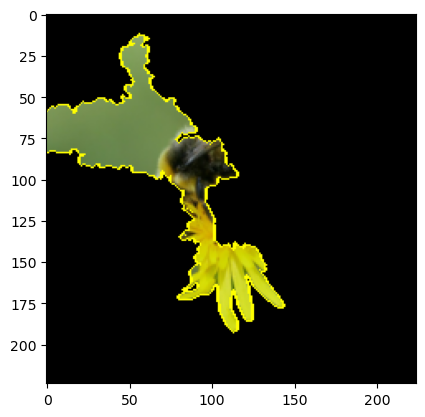

In [40]:
temp, mask = explanation_squeezenet.\
             get_image_and_mask(explanation_squeezenet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [41]:
# temp, mask = explanation_squeezenet.\
#              get_image_and_mask(explanation_squeezenet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

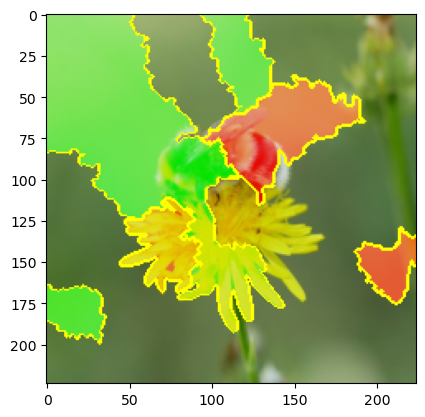

In [42]:
temp, mask = explanation_squeezenet.\
             get_image_and_mask(explanation_squeezenet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

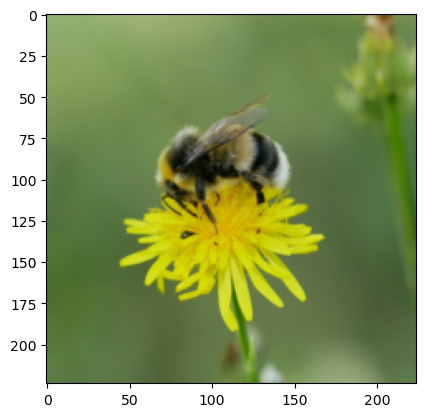

In [43]:
temp, mask = explanation_squeezenet.\
             get_image_and_mask(explanation_squeezenet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 255.0, mask))

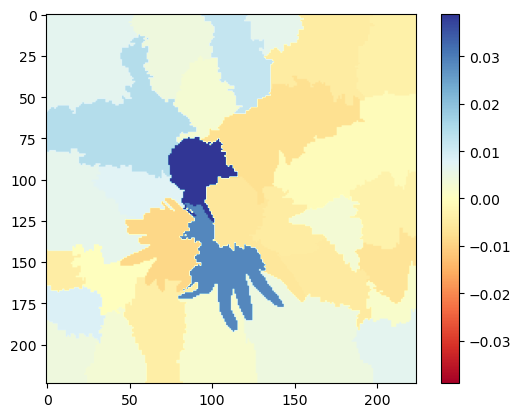

In [44]:
visualize_explanation_pytorch(explanation_squeezenet)

<br> </br>
## 4.2.2 DenseNet121
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/')
# Create an instance of the DenseNet model
model_densenet = models.densenet121(num_classes=num_classes, pretrained=False)

# Load the saved model weights
model_densenet.load_state_dict(torch.load("model_densenet.pth"))

# Set the model to evaluation mode
model_densenet.eval()

In [ ]:
print_accuracy_pytorch(model_densenet, test_loader, 'DenseNet121')

In [ ]:
plot_confusion_matrix_test_pytorch(model_densenet, test_loader, 'DenseNet121')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/test')

In [ ]:
lucorum = get_image('./bombus lucorum/bombus lucorum inaturalist 13.jpg')
plt.imshow(lucorum)

In [ ]:
pytorch_predict(model_densenet, './bombus lucorum/bombus lucorum inaturalist 13.jpg')

In [ ]:
print(class_names)

In [ ]:
lucorum_tensor = get_input_tensors(lucorum)
model_densenet.eval()
logits = model_densenet(lucorum_tensor)

In [ ]:
print(logits)

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [ ]:
def batch_predict_densenet(images):
    model_densenet.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_densenet.to(device)
    batch = batch.to(device)
    
    logits = model_densenet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred_densenet = batch_predict_densenet([image_transform(lucorum)])
class_label = test_pred_densenet.squeeze().argmax()
print(f'The top one predicted class label is {class_label}.')
print(f'The top one predicted class name is: {class_names[class_label]}.')

In [ ]:
explanation_densenet = explainer.explain_instance(np.array(image_transform(lucorum)), 
                                                  batch_predict_densenet,
                                                  top_labels=5, 
                                                  hide_color=0, 
                                                  num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_densenet.\
             get_image_and_mask(explanation_densenet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
# temp, mask = explanation_densenet.\
#              get_image_and_mask(explanation_densenet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_densenet.\
             get_image_and_mask(explanation_densenet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_densenet.\
             get_image_and_mask(explanation_densenet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
visualize_explanation_pytorch(explanation_densenet)

<br> </br>
## 4.2.3 ShuffleNetV2
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/')
# Create an instance of the ShuffleNet model
model_shufflenet = models.shufflenet_v2_x2_0(num_classes=num_classes, pretrained=False)

# Load the saved model weights
model_shufflenet.load_state_dict(torch.load("model_shufflenet.pth"))

# Set the model to evaluation mode
model_shufflenet.eval()

In [ ]:
print_accuracy_pytorch(model_shufflenet, test_loader, 'ShuffleNetV2')

In [ ]:
plot_confusion_matrix_test_pytorch(model_shufflenet, test_loader, 'ShuffleNetV2')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/test')

In [ ]:
lucorum = get_image('./bombus lucorum/bombus lucorum inaturalist 13.jpg')
plt.imshow(lucorum)

In [ ]:
pytorch_predict(model_shufflenet, './bombus lucorum/bombus lucorum inaturalist 13.jpg')

In [ ]:
print(class_names)

In [ ]:
lucorum_tensor = get_input_tensors(lucorum)
model_shufflenet.eval()
logits = model_shufflenet(lucorum_tensor)

In [ ]:
print(logits)

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [ ]:
def batch_predict_shufflenet(images):
    model_shufflenet.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_shufflenet.to(device)
    batch = batch.to(device)
    
    logits = model_shufflenet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred_shufflenet = batch_predict_shufflenet([image_transform(lucorum)])
class_label = test_pred_shufflenet.squeeze().argmax()
print(f'The top one predicted class label is {class_label}.')
print(f'The top one predicted class name is: {class_names[class_label]}.')

In [ ]:
explanation_shufflenet = explainer.explain_instance(np.array(image_transform(lucorum)), 
                                                    batch_predict_shufflenet,
                                                    top_labels=5, 
                                                    hide_color=0, 
                                                    num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_shufflenet.\
             get_image_and_mask(explanation_shufflenet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
# temp, mask = explanation_shufflenet.\
#              get_image_and_mask(explanation_shufflenet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_shufflenet.\
             get_image_and_mask(explanation_shufflenet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_shufflenet.\
             get_image_and_mask(explanation_shufflenet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
visualize_explanation_pytorch(explanation_shufflenet)

<br> </br>
## 4.2.4 GoogleNet
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/')
# Create an instance of the GoogleNet model
model_googlenet = models.googlenet(num_classes=num_classes, pretrained=False)

# Load the saved model weights
model_googlenet.load_state_dict(torch.load("model_googlenet.pth"))

# Set the model to evaluation mode
model_googlenet.eval()

In [ ]:
print_accuracy_pytorch(model_googlenet, test_loader, 'GoogleNet')

In [ ]:
plot_confusion_matrix_test_pytorch(model_googlenet, test_loader, 'GoogleNet')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/test')

In [ ]:
pascuorum = get_image('./bombus pascuorum/bombus pascuorum male 43.jpg')
plt.imshow(pascuorum)

In [ ]:
pytorch_predict(model_googlenet, './bombus pascuorum/bombus pascuorum male 43.jpg')

In [ ]:
print(class_names)

In [ ]:
pascuorum_tensor = get_input_tensors(pascuorum)
model_googlenet.eval()
logits = model_googlenet(pascuorum_tensor)

In [ ]:
print(logits)

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [ ]:
def batch_predict_googlenet(images):
    model_googlenet.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_googlenet.to(device)
    batch = batch.to(device)
    
    logits = model_googlenet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred_googlenet = batch_predict([image_transform(pascuorum)])
class_label = test_pred_googlenet.squeeze().argmax()
print(f'The top one predicted class label is {class_label}.')
print(f'The top one predicted class name is: {class_names[class_label]}.')

In [ ]:
explanation_googlenet = explainer.explain_instance(np.array(image_transform(pascuorum)), 
                                                   batch_predict_googlenet,
                                                   top_labels=5, 
                                                   hide_color=0, 
                                                   num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_googlenet.\
             get_image_and_mask(explanation_googlenet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
# temp, mask = explanation_googlenet.\
#              get_image_and_mask(explanation_googlenet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_googlenet.\
             get_image_and_mask(explanation_googlenet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_googlenet.\
             get_image_and_mask(explanation_googlenet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
visualize_explanation_pytorch(explanation_googlenet)

<br> </br>
## 4.2.5 MNASNET1_0
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/')
# Create an instance of the SqueezeNet model
model_mnasnet = models.mnasnet1_0(num_classes=num_classes, pretrained=False)

# Load the saved model weights
model_mnasnet.load_state_dict(torch.load("model_mnasnet.pth"))

# Set the model to evaluation mode
model_mnasnet.eval()

In [ ]:
print_accuracy_pytorch(model_mnasnet, test_loader, 'MNASNET1_0')

In [ ]:
plot_confusion_matrix_test_pytorch(model_mnasnet, test_loader, 'MNASNET1_0')

<br> </br>
<h1 style="font-size: 28px; text-align: center; color: purple"> LIME Evaluation </h1>
<br> </br>

In [ ]:
os.chdir('/home/hduser/Desktop/final dataset testing/test')

In [ ]:
pascuorum = get_image('./bombus pascuorum/bombus pascuorum male 43.jpg')
plt.imshow(pascuorum)

In [ ]:
pytorch_predict(model_mnasnet, './bombus pascuorum/bombus pascuorum male 43.jpg')

In [ ]:
print(class_names)

In [ ]:
pascuorum_tensor = get_input_tensors(pascuorum)
model_mnasnet.eval()
logits = model_mnasnet(pascuorum_tensor)

In [ ]:
print(logits)

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, class_names[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

In [ ]:
def batch_predict_mnasnet(images):
    model_mnasnet.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_mnasnet.to(device)
    batch = batch.to(device)
    
    logits = model_mnasnet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred_mnasnet = batch_predict_mnasnet([image_transform(pascuorum)])
class_label = test_pred_mnasnet.squeeze().argmax()
print(f'The top one predicted class label is {class_label}.')
print(f'The top one predicted class name is: {class_names[class_label]}.')

In [ ]:
explanation_mnasnet = explainer.explain_instance(np.array(image_transform(pascuorum)), 
                                                 batch_predict_mnasnet,
                                                 top_labels=5, 
                                                 hide_color=0, 
                                                 num_samples=1000)

<br> </br>
- top 3 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation_mnasnet.\
             get_image_and_mask(explanation_mnasnet.top_labels[0], 
                                positive_only=True, 
                                num_features=3, 
                                hide_rest=True)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
# temp, mask = explanation_mnasnet.\
#              get_image_and_mask(explanation_mnasnet.top_labels[0], 
#                                 positive_only=True, 
#                                 num_features=3, 
#                                 hide_rest=False)
# plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation_mnasnet.\
             get_image_and_mask(explanation_mnasnet.top_labels[0], 
                                positive_only=False, 
                                num_features=10, 
                                hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation_mnasnet.\
             get_image_and_mask(explanation_mnasnet.top_labels[0], 
                                positive_only=False, 
                                num_features=1000, 
                                hide_rest=False, 
                                min_weight=0.1)
plt.imshow(mark_boundaries(temp / 255.0, mask))

In [ ]:
visualize_explanation_pytorch(explanation_mnasnet)